# Zindi Challenge Participant Notebook

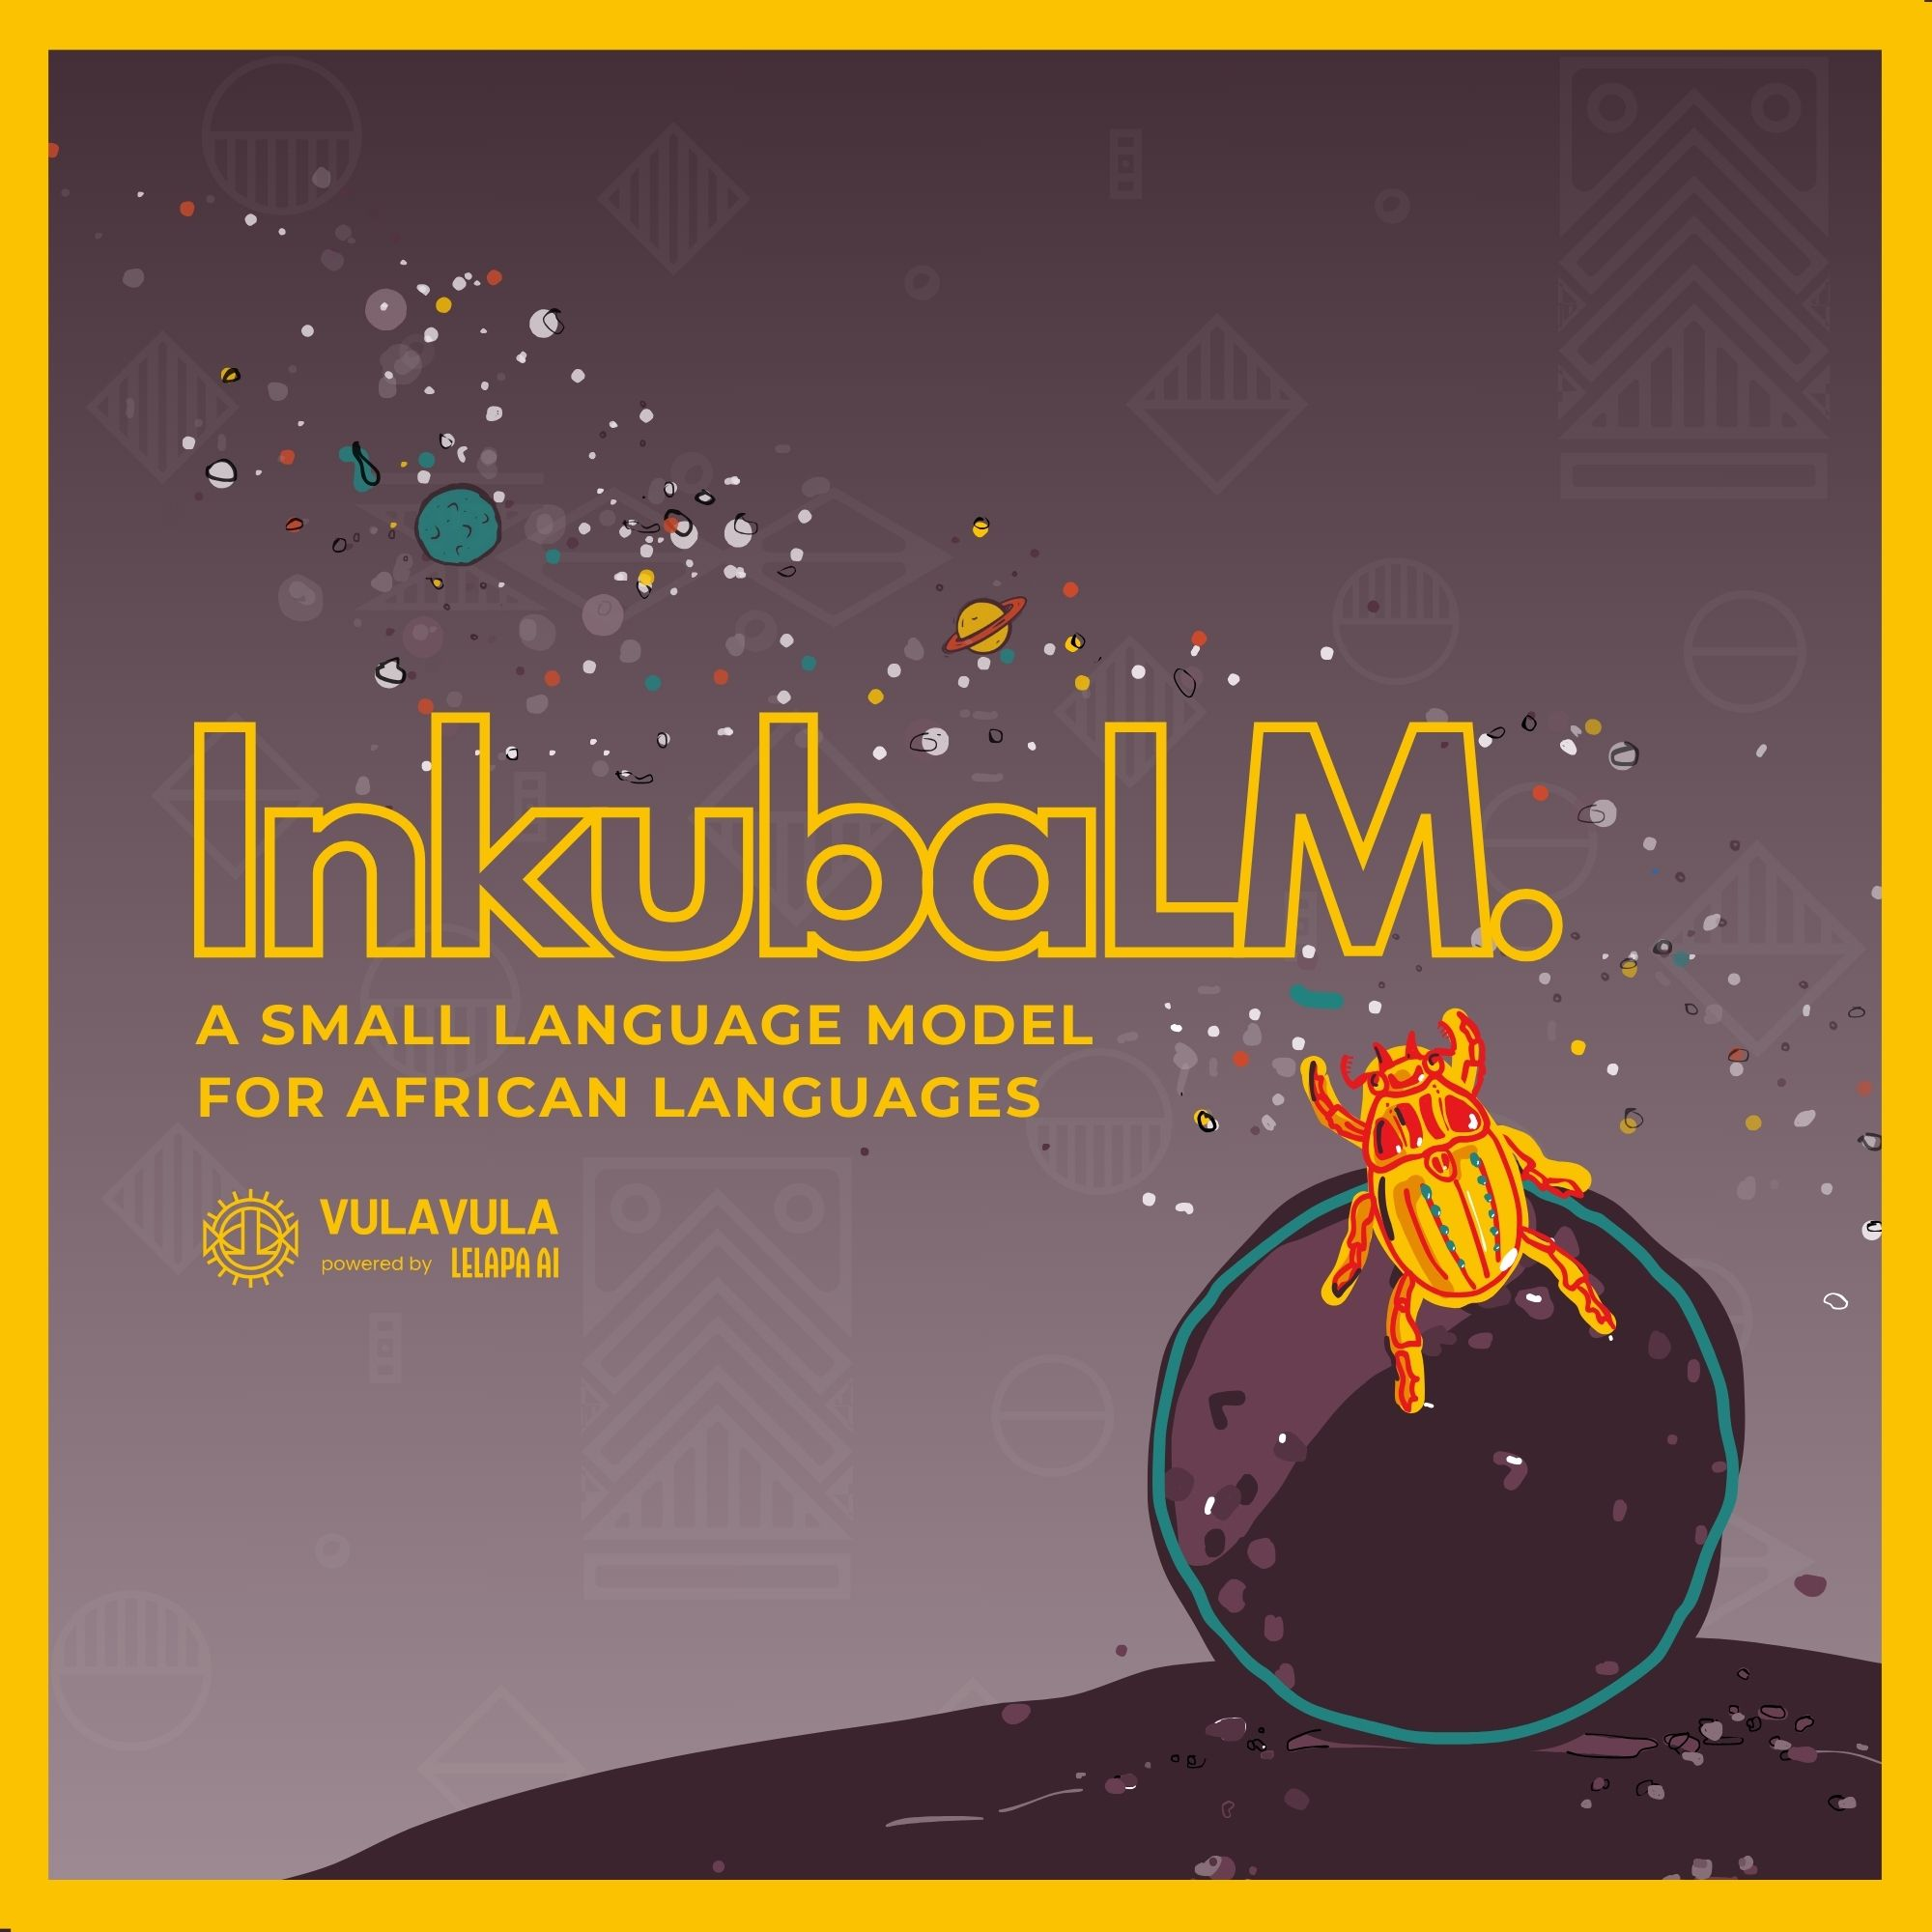

This Notebook and its associated files `model_function.py` and `eval.py` together act to assist participants in:

*   Step 1: testing performance of models on the desired tasks
*   Step 2: create a dev set submisison file to test performance on the Lelapa AI Zindi score
*   Step 3: finally, create a submission file on the test set to upload to the Zindi platform

### 🪲 The InkubaLM
InkubaLM is a Small Language Model with functionality in Kiswahili, Hausa, Yoruba, isiZulu and isiXhosa. For simplicity sake we are only including two of these languages in this challenge (Kiswahili and Hausa) and although the model is a geneartive base model in this case we are only evaluating three tasks - Sentiment Analysis, Machine Translation and AfriXNLI: The ability to derive whether a statement is True, False or Neither (Note: We only do the eng->x direction for translation because that is typically the direction that has the least performance). By testing on 2 languages and 3 tasks we are able to get a good sense on the generalization capability of the model.

### 🏆 The Lelapa AI Zindi score:
The goal of this challenge is to have a model that is smaller than InkubaLM but performs better than InkubaLM. So, the final score is a combination of how well the model performs as well as the model size.

Options to make the model smaller include:

*   Using a new and improved model architecture
*   Using model size reducing techniques

Options to make the model perfrom better include:

*   Prompt engineering to determine the best prompting of outputs
*   Fine tuning of the Inkuba model
*   Model ensembling methods

But methods are not limited to those listed here. And we are excited to see what everyone will come up with.

### 📄 Datasets
Dev - Contains a target. The dev set consists of 100 examples for each task and each language (600 samples in total), you will be required to split this into your own training and test sets.

Test - Does not contain a target. Only consists of 50 samples per language per task (300 samples in total). You will need to use the entire set to create you submission file

### 💻 Compute
It is possible to run this notebook on CPU - it just takes a while. You are able to change your free notebook to use GPU compute for a limited time and that makes the notebook run much faster! 

You can also run the functions on your local machine accessing your local CPU/GPU. We have made a concerted efffort to ensure that those who do not have access to significant compute can still participate in this challenge.


Open notebook in Colab -> https://colab.research.google.com/drive/19wIzsBFiYdnFz1rIoKhsrrTGem8mZzbc?usp=sharing

## Load Useful functions

We have added some code that allows you to run on GPU if available. You can select:
Runtime -> Change runtime type -> T4 if you are on a colab notebook in order to enable GPU



**You will need a Huggingface account to be able to access the datasets and the models**

Make sure you have generated an HF_TOKEN and added it to your notebook. You can find instruction son how to do this here https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/Gemma_Basics_with_HF.ipynb

🚨 NB: In order to access the Inkuba model, make sure you have requested and granted access to the Gated InkubaLM model on huggingface.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")  # Add parent directory to the path

import os
from typing import List

import numpy as np

# DO NOT EDIT
# create submission file
import pandas as pd
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
)
from utils import (
    eval,
    model_function,  # functions to load model and run inference
)


In [3]:
offline = False
output_path = "../Output/"

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [5]:
data_path = "../Input"

In [ ]:
try:
    from google.colab import userdata

    # Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
    # vars as appropriate for your system.
    # userdata.get("HF_TOKEN") indicates that the name of the token in the Colab env is HF_TOKEN
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except:
    os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
    

login(token=os.environ["HF_TOKEN"])


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
def process_likelihood(likelihood_str: str) -> List[float]:
    """
    Process a likelihood string to clean and convert it to a list of floats.
    """
    # Clean the string to remove unwanted characters
    clean_str = (
        likelihood_str.replace("tensor(", "").replace(")", "").strip()
        .replace("[[", "").replace("]]", "").strip()
        .replace(" device='cuda:0'", "").replace(" dtype=torch.float16", "").strip()
        .replace("tensor", "").strip()
    )

    # Remove any empty strings caused by extra commas
    clean_str = clean_str.replace(",,", ",")  # Remove duplicate commas if they exist

    # Convert to a list of floats
    likelihood = [
        float(x) for x in clean_str.split(",") if x.strip()
    ]  # Ensure non-empty strings are converted
    return likelihood

def create_submission(output_path, test_flag: bool):
    """
    Creates submission files based on the provided test_flag.

    Args:
    test_flag (bool): If True, creates a test submission file; otherwise, creates a final submission file.
    """
    if test_flag:
        try:
            df1 = pd.read_csv(os.path.join(
                output_path,
                "hau_sent_prediction_dev.csv")
                 )
            df2 = pd.read_csv(os.path.join(
                output_path,
                "swa_sent_prediction_dev.csv")
            )
            df3 = pd.read_csv(os.path.join(
                output_path,
                "hau_mt_prediction_dev.csv")
                             )
            df4 = pd.read_csv(os.path.join(
                output_path,
                "swa_mt_prediction_dev.csv"))
            df5 = pd.read_csv(os.path.join(
                output_path,
                "hau_xnli_prediction_dev.csv"))
            df6 = pd.read_csv(os.path.join(
                output_path,
                "swa_xnli_prediction_dev.csv"))
        except FileNotFoundError as e:
            print(
                "Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file"
            )
            raise e
    else:
        filename = "submission.csv"
        try:
            df1 = pd.read_csv(os.path.join(
                output_path,
                "hau_sent_prediction.csv"))
            df2 = pd.read_csv(os.path.join(
                output_path,
                "swa_sent_prediction.csv"))
            df3 = pd.read_csv(os.path.join(
                output_path,
                "hau_mt_prediction.csv"))
            df4 = pd.read_csv(os.path.join(
                output_path,
                "swa_mt_prediction.csv"))
            df5 = pd.read_csv(os.path.join(
                output_path,
                "hau_xnli_prediction.csv"))
            df6 = pd.read_csv(os.path.join(
                output_path,
                "swa_xnli_prediction.csv"))
        except FileNotFoundError as e:
            print(
                "Seems you have not completed all the tasks, please complete all the tasks before attempting to create your submission file"
            )
            raise e

    # Combine and process data
    resmt = pd.concat([df3, df4], ignore_index=True)
    res_log = pd.concat([df1, df2, df5, df6], ignore_index=True)
    res_log.drop(columns=["Response"], inplace=True)
    res_log.rename(columns={"Log-Likelihood": "Response"}, inplace=True)
    res = pd.concat([res_log, resmt], ignore_index=True)

    def process_row(row):
        if "xnli" in row["ID"] or "sent" in row["ID"]:
            likelihoods = process_likelihood(row["Response"])
            predicted_label = np.argmax(likelihoods)
            return predicted_label
        return row["Response"]  # Default for other cases

    # Update the Response column in-place
    res["Response"] = res.apply(process_row, axis=1)

    if test_flag:
        filename = os.path.join(
                output_path,
                "submission_test.csv")
        # Save the submission file
        submission = res[["ID", "Response", "Targets"]]
        submission.to_csv(filename, index=False)
    else:
        filename = os.path.join(
                output_path,
                "submission.csv")
        # Save the submission file
        submission = res[["ID", "Response"]]
        submission.to_csv(filename, index=False)
    return submission

## Load your model

Functions that load the model functions, eval functions and datasets

If you encounter a problem, please refer to this [discussion](https://discuss.huggingface.co/t/your-request-to-access-this-repo-has-been-successfully-submitted-and-is-pending-a-review-from-the-repos-authors/57698) 

In [8]:
if offline:
    os.environ["TRANSFORMERS_OFFLINE"] = "0"

In [9]:
model_name = "lelapa/InkubaLM-0.4B"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=os.environ["HF_TOKEN"])
model = model_function.load_model(model_name)

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:810: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.11/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-01-09 10:54:08.438699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 10:54:08.438754: E external/local_xla/xla/stream_execu

# TEST INFERENCE AND SCORING ON THE DEV SET

## Step 1: Get results for all the tasks and all the languages and save them to separate CSV files

Essentially this part cycles through each of the languages for each of the tasks (Hausa + Swahili - Sentiment, MT and XNLI). This produces 6 files.

Customisation options:

*   `sample_size` change this to determine how many samples to generate results for, useful for testing
*   `custom_instruct` If you want to use an instruction that is different to what is currently available in the dataset
*   `BASE_PROMPT` change this to change the base prompt
*   `max_new_tokens` this is the number of tokens that are generated, for sentiment and XNLI we expect one word answers, so the number of tokens can be smaller. For translation though, the default is 100



The BASE_PROMPT can be changed in a prompt engineering exercise to see whether performance can be improved through better prompts. Task instructions can also be adjusted to see if they improve results (ensure to change `custom_instruct=True` in order to use custom instruct statements)

In [10]:
BASE_PROMPT = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n ### Instruction: {}\n\n ### Response: "

## Run Sentiment inference sample and create sentiment files

Load dev datasets for the sentiment task for hausa and swahili

In [11]:
from datasets import Dataset, DatasetDict

# Load the Swahili dataset from a local CSV file
sentiment_train_df = pd.read_csv(
    os.path.join(data_path, "SentimentTrain.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='hausa']
)
swa_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='swahili']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)


Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 200
})
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 200
})


Load the instruction for sentiment

In [12]:
# don't change this instruction
sent_instruction = "Please identify the sentiment reflected in this text based on the following guidelines: Positive: if a text implies positive sentiment, attitude, and emotional state. Negative: if a text implies negative sentiment or emotion. Neutral: if a text does not imply positive or negative language directly or indirectly. Provide sentiment labels only"

Run model inference and generate inference files for sentiment

🚨 NB: You can change the `sample_size` here for quicker iterations during development. However, to get a real sense of performance, we recommend ensuring this sample_size is 50

In [13]:
# for swahili
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    max_new_tokens=15,
    task_instruction=sent_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_sent_prediction_dev.csv"
    ),
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [14]:
# for hausa
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    task_instruction=sent_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_sent_prediction_dev.csv"
    ),
    max_new_tokens=15,
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## Run MT inference and create MT files

Load Dev sets for MT task for Hausa and Swahili

In [15]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load the Swahili dataset from a local CSV file
sentiment_train_df = pd.read_csv(
    os.path.join(data_path, "MTTrain.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='eng-hau']
)
swa_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='eng-swa']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)


Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 300
})
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 300
})


Load the instruction for MT

In [16]:
# don't change this instruction
mt_instruction = "Translate the following from {input_lang} into {output_lang}."

Run model inference and generate inference files for machine translation

In [17]:
# for hausa
hau_mt_instruction = mt_instruction.format(input_lang="English", output_lang="Hausa")
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    task_instruction=hau_mt_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_mt_prediction_dev.csv"
    ),
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [18]:
# for swahili
swa_mt_instruction = mt_instruction.format(input_lang="English", output_lang="Swahili")
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    task_instruction=swa_mt_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_mt_prediction_dev.csv"
    ),
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


## Run XNLI inference and generate inference files for XNLI task

Load Dev and Test sets for Xnli task for Hausa and Swahili

In [19]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Load the Swahili dataset from a local CSV file
sentiment_train_df = pd.read_csv(
    os.path.join(data_path, "XNLITrain.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='hau']
)
swa_dataset = Dataset.from_pandas(
    sentiment_train_df[sentiment_train_df['langs']=='swa']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)


Dataset({
    features: ['ID', 'langs', 'premise', 'inputs', 'instruction', 'targets', '__index_level_0__'],
    num_rows: 200
})
Dataset({
    features: ['ID', 'langs', 'premise', 'inputs', 'instruction', 'targets', '__index_level_0__'],
    num_rows: 200
})


Load the instruction for AfriXnli

In [20]:
# Instruction is derived from the dataset custom_instruct = False
# If you would like to try your own instruction thenedit the text below and edit:
# custom_instruct = True
xnli_instruction = "Is the following question True, False or Neither?"

Run model inference and generate inference files for AfriXnli translation

In [21]:
# for hausa
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    task_instruction=xnli_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_xnli_prediction_dev.csv"
    ),
    max_new_tokens=15,
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [22]:
# for swahili
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=3,
    task_instruction=xnli_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_xnli_prediction_dev.csv"
    ),
    max_new_tokens=15,
    custom_instruct=False,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


# Step 2: Check how well your model is performing on the Lelapa AI Zindi Scoreboard with this custom evaluation function

## Test your dev set performance

To get a test Submission file with the dev set and calculate a score, use the submission file test code below to see what your score is

In [23]:
create_submission(output_path=output_path, test_flag=True)

,ID,Response,Targets
0,ID_6aba33a1_sentiment_ dev_hausa,1,Kyakkyawa
1,ID_ce64d307_sentiment_ dev_hausa,1,Tsaka-tsaki
2,ID_2efc9515_sentiment_ dev_hausa,1,Tsaka-tsaki
3,ID_dfb02831_sentiment_ dev_swahili,1,Wastani
4,ID_ad1d9888_sentiment_ dev_swahili,1,Wastani
5,ID_34eed91d_sentiment_ dev_swahili,1,Wastani
6,ID_648d37ff_dev_afrixnli_hau,1,0
7,ID_f96a39cb_dev_afrixnli_hau,1,0
8,ID_99a61e3d_dev_afrixnli_hau,1,2
9,ID_4c5d953b_dev_afrixnli_swa,1,1


In [24]:
eval.evaluate_zindi(os.path.join(
    output_path,
    "submission_test.csv")
)

/notebooks/zindi-consulting/inkuba-lelapa/zindi-inkuba-notebook/Notebooks/../utils/eval.py:110: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  TP = np.sum((true_labels == i) & (pred_labels == i))  # True Positives
/notebooks/zindi-consulting/inkuba-lelapa/zindi-inkuba-notebook/Notebooks/../utils/eval.py:111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  FP = np.sum((true_labels != i) & (pred_labels == i))  # False Positives
/notebooks/zindi-consulting/inkuba-lelapa/zindi-inkuba-notebook/Notebooks/../utils/eval.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  FN = np.sum((true_labels == i) & (pred_labels != i))  # False Negatives


7.48

# CREATE YOUR SUBMISSION FILE

# Use this code to run inference on the submission test set and combine all files into a single submission file

In [25]:
# model = ""

Once you are satisifed with the performance on the dev set, create your prediction files from the test set to create your submission.

This code takes a fair amount of compute resources to run. It combines two test sets for a total of 200 samples per language per task.

In [26]:
BASE_PROMPT = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n ### Instruction: {}\n\n ### Response: "

Generate sentiment files

In [27]:
# Load the Swahili dataset from a local CSV file
sentiment_test_df = pd.read_csv(
    os.path.join(data_path, "SentimentTest.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    sentiment_test_df[sentiment_test_df['langs']=='hausa']
)
swa_dataset = Dataset.from_pandas(
    sentiment_test_df[sentiment_test_df['langs']=='swahili']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 150
})
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 150
})


In [ ]:
sent_instruction = "Please identify the sentiment reflected in this text based on the following guidelines: Positive: if a text implies positive sentiment, attitude, and emotional state. Negative: if a text implies negative sentiment or emotion. Neutral: if a text does not imply positive or negative language directly or indirectly. Provide sentiment labels only"  # edit this if you have a custom instruction

model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=sent_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_sent_prediction.csv"
    ),
    max_new_tokens=15,
    custom_instruct=False,
)
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=sent_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_sent_prediction.csv"),
    max_new_tokens=15,
    custom_instruct=False,
)


Generate AfriXnli files

In [29]:
# Load the Swahili dataset from a local CSV file
xnli_test_df = pd.read_csv(
    os.path.join(data_path, "XNLITest.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    xnli_test_df[xnli_test_df['langs']=='hau']
)
swa_dataset = Dataset.from_pandas(
    xnli_test_df[xnli_test_df['langs']=='swa']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)

Dataset({
    features: ['ID', 'langs', 'premise', 'inputs', 'instruction', 'targets', '__index_level_0__'],
    num_rows: 150
})
Dataset({
    features: ['ID', 'langs', 'premise', 'inputs', 'instruction', 'targets', '__index_level_0__'],
    num_rows: 150
})


In [ ]:
xnli_instruction = "Is the following question True, False or Neither?"  # edit this if you have a custom instruction
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=xnli_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_xnli_prediction.csv"),
    max_new_tokens=15,
    custom_instruct=False,
)
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=xnli_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_xnli_prediction.csv"),
    max_new_tokens=15,
    custom_instruct=False,
)

Generate MT files

In [31]:
# Load the Swahili dataset from a local CSV file
xnli_test_df = pd.read_csv(
    os.path.join(data_path, "MTTest.csv")
)  # Replace with your actual file path


hau_dataset = Dataset.from_pandas(
    xnli_test_df[xnli_test_df['langs']=='eng-hau']
)
swa_dataset = Dataset.from_pandas(
    xnli_test_df[xnli_test_df['langs']=='eng-swa']
)

# If you need a DatasetDict to mimic the Hugging Face structure
dataset_dict = DatasetDict({
    "swahili": swa_dataset,
    "hausa": hau_dataset
})

# Print to verify
print(swa_dataset)
print(hau_dataset)

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 150
})
Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', '__index_level_0__'],
    num_rows: 150
})


In [ ]:
mt_instruction = "Translate the following from {input_lang} into {output_lang}."
swa_mt_instruction = mt_instruction.format(input_lang="English", output_lang="Swahili")
hau_mt_instruction = mt_instruction.format(input_lang="English", output_lang="Hausa")

model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=hau_mt_instruction,
    dataset=hau_dataset,
    csv_file_path=os.path.join(
        output_path,
        "hau_mt_prediction.csv"),
    custom_instruct=False,
)
model_function.main(
    model,
    tokenizer,
    BASE_PROMPT,
    sample_size=150,
    task_instruction=swa_mt_instruction,
    dataset=swa_dataset,
    csv_file_path=os.path.join(
        output_path,
        "swa_mt_prediction.csv"),
    custom_instruct=False,
)

Now create your submission file. Make sure you name the files correctly so that you do not have issues creating the submission file

In [33]:
create_submission(output_path=output_path, test_flag=False)

,ID,Response
0,ID_f3c74c7b_sentiment_test__hausa,1
1,ID_aad19dbf_sentiment_test__hausa,1
2,ID_f6de0381_sentiment_test__hausa,1
3,ID_885caf5c_sentiment_test__hausa,1
4,ID_7b906b9a_sentiment_test__hausa,1
...,...,...
895,ID_d054836f_test__mt_eng-swa,ẽwa (a) in hausa. Below is an instruction that...
896,ID_863222b7_test__mt_eng-swa,ḇedai ḇesyaku. Below is an instruction thatund...
897,ID_c5df2cca_test__mt_eng-swa,����������������������������������������������...
898,ID_eda1ff7d_test__mt_eng-swa,����������������������������������������������...
